<a href="https://colab.research.google.com/github/pakdaniel/DataMiningFinal/blob/main/DataMiningFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
# !pip install vit-pytorch
# !pip install datasets
# !pip install transformers

In [1]:
# import tensorflow as tf
import numpy as np 
import math
import random
import matplotlib.pyplot as plt
import os 
import sys
import librosa
import librosa.display
from warnings import warn
from IPython.display import Audio, display
from scipy import signal 
from scipy.io import wavfile
from collections import Counter
import time
import pandas as pd

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torchaudio
from torchaudio import transforms
from vit_pytorch import ViT

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

COLAB = False

In [2]:
if COLAB:
    from google.colab import drive
    drive_root = '/content/drive'
    drive.mount(drive_root)
    VIVAE_PATH = os.path.join(drive_root, "My Drive", "VIVAE", "full_set")
else:
    VIVAE_PATH = os.path.join("../VIVAE", "full_set")
    
audio_paths = [os.path.join(VIVAE_PATH, i) for i in os.listdir(VIVAE_PATH)]
audio_paths.sort()

In [3]:
def save_model(model, save_dir, epoch, test_loss, test_acc):
    model_folder_name = f'epoch_{epoch:05d}_test_loss_{test_loss:.5f}_test_acc_{test_acc:.3f}'
    if not os.path.exists(os.path.join(save_dir, model_folder_name)):
        os.makedirs(os.path.join(save_dir, model_folder_name))
    torch.save(model.state_dict(), os.path.join(save_dir, model_folder_name, 'model.pth'))
    
def save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir):
    logs_dict = {"epoch": [i for i in range(1,EPOCHS+1)],	
                 "train_loss": 	train_losses,
                 "train_accuracy": train_accs,
                 "eval_loss": test_losses,
                 "eval_accuracy": test_accs}
    df = pd.DataFrame(logs_dict)
    df.to_pickle(os.path.join(output_dir, "logs.pkl"))
    return df

def plot_loss(df, title=None):
    plt.figure(figsize=(8,6))
    plt.plot(df["epoch"], df["train_loss"], label="Training Loss")
    plt.plot(df["epoch"], df["eval_loss"], label="Testing Loss")
    plt.legend()
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    if title:
        plt.title(title, fontsize=12)
    plt.show()

def plot_accuracy(df, title=None):
    plt.figure(figsize=(8,6))
    plt.plot(df["epoch"], df["train_accuracy"], label="Training Acc")
    plt.plot(df["epoch"], df["eval_accuracy"], label="Testing Acc")
    plt.legend()
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    if title:
        plt.title(title, fontsize=12)
    plt.show()

# Distribution and Creation of Labels

In [4]:
def all_labels(inp):
    emotion_type = []
    emotion_intensities = []
    emotion_labels = []

    for file_name in audio_paths:
        metadata = file_name.split("/")[-1].split("_")
        emotion_type.append(metadata[1]) 
        emotion_intensities.append(metadata[2])
        emotion_labels.append(metadata[1] + "_" + metadata[2])

    res = dict()

    if inp == "emotion_type":
        for i in emotion_type:
            if i not in res:
                res[i] = 1
            else:
                res[i] += 1
    elif inp == "emotion_intensity":
        for i in emotion_intensities:
            if i not in res:
                res[i] = 1
            else:
                res[i] += 1
    elif inp == "emotion_full_label":
        for i in emotion_labels:
            if i not in res:
                res[i] = 1
            else:
                res[i] += 1

    res = dict(sorted(res.items()))

    label_encoding = {}
    for count, val in enumerate(res):
        label_encoding[val] = count

    return label_encoding

LABEL_TYPE = "emotion_type"
LABEL_ENCODING = all_labels(LABEL_TYPE) 

LABEL_ENCODING

{'achievement': 0,
 'anger': 1,
 'fear': 2,
 'pain': 3,
 'pleasure': 4,
 'surprise': 5}

# Creating Audio Class Using torchaudio 

In [5]:
class Audio():
  def __init__(self, audio_file, label_type, label_mapping):
    self.audio_file = audio_file
    self.open()
    self.set_labels(label_type, label_mapping)

  def open(self):
    self.audio, self.sr = torchaudio.load(self.audio_file)

  def set_labels(self, label_type, label_mapping):
    metadata = self.audio_file.split("/")[-1].split("_")
    self.subject = metadata[0]
    if label_type == "emotion_type":
      self.label = metadata[1]
    elif label_type == "emotion_intensity":
      self.label = metadata[2]
    elif label_type == "emotion_full_label":
      self.label = metadata[1] + "_" + metadata[2]
    self.label_encoding = label_mapping[self.label]

  def get_audio(self):
    return self.audio

  def plot_time_series(self, audio):
    t = np.arange(audio.size()[1])/self.sr
    plt.figure(figsize=(8,6))
    plt.plot(t, audio.squeeze().detach().numpy())
    plt.xlabel("Time (s)", fontsize=12)
    plt.title("Time Series", fontsize=12)
    plt.show()

  def mel_spectrogram(self, audio, hop_length=64, n_fft=1024, n_mels=64, top_db=80):
    spec = transforms.MelSpectrogram(self.sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(audio)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return spec

  def plot_mel_spectrogram(self, audio, hop_length=64, n_fft=1024, n_mels=64, top_db=80):
    spec = self.mel_spectrogram(audio, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels, top_db=top_db).detach().squeeze().numpy()
    plt.figure(figsize=(8,6))
    librosa.display.specshow(spec, sr=self.sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');
    plt.title('Mel Spectrogram', fontsize=12);
  
  def get_mel_spectrogram_and_label(self, audio, n_mels):
    return self.mel_spectrogram(audio, n_mels=n_mels), self.label_encoding

  def get_time_series_and_label(self, audio):
    return audio.squeeze(), self.label_encoding

  def pad_time_series(self, audio, max_length):
    assert audio.dim() == 2, "Audio should be of dim 2"
    curr_len = audio.size()[1]

    # get beginning part of time series
    if curr_len > max_length:
      audio = audio[:,:max_length]
    
    # two sided padding
    elif curr_len < max_length:
      left = math.floor((max_length-curr_len)/2)
      right = (max_length-curr_len)-left
      audio = F.pad(audio, (left,right), "constant", 0)

    return audio  
  
  def resample(self, audio, sr, resample_sr):
    resampler = transforms.Resample(sr, resample_sr)
    resampled_audio = resampler(audio)
    return resampled_audio

torch.Size([1, 21125])


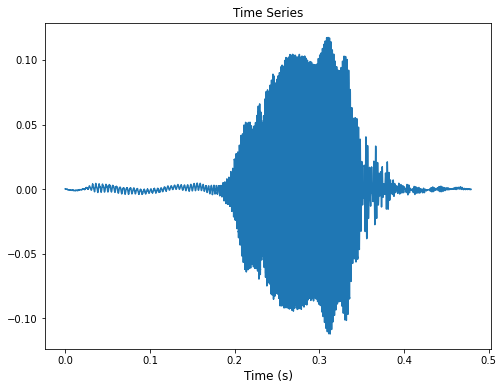

torch.Size([1, 30000])


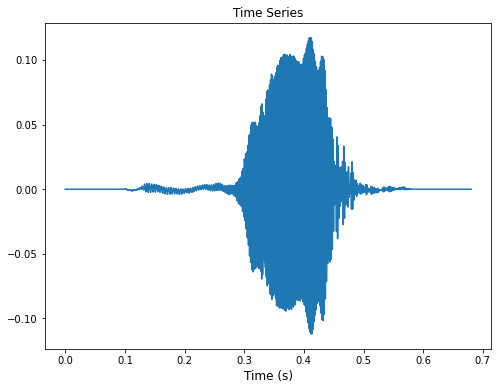

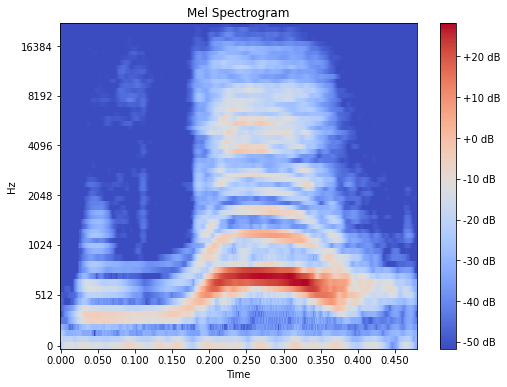

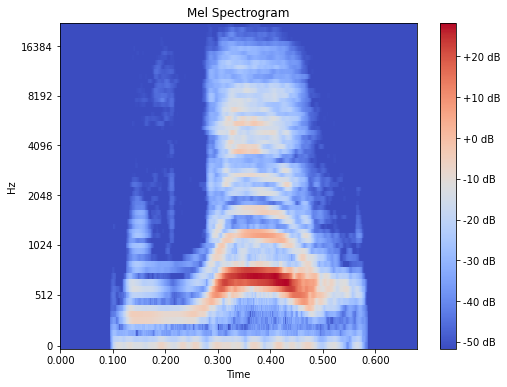

In [200]:
test = Audio(audio_paths[0], LABEL_TYPE, LABEL_ENCODING)
aud = test.get_audio()
padded_aud = test.pad_time_series(aud, 30000)

print(aud.size())
test.plot_time_series(aud)

print(padded_aud.shape)
test.plot_time_series(padded_aud)

test.plot_mel_spectrogram(aud)
test.plot_mel_spectrogram(padded_aud)


In [ ]:
# def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
#   # https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
#   fig, axs = plt.subplots(1, 1)
#   axs.set_title(title or 'Spectrogram (db)')
#   axs.set_ylabel(ylabel)
#   axs.set_xlabel('frame')
#   im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
#   if xmax:
#     axs.set_xlim((0, xmax))
#   fig.colorbar(im, ax=axs)
#   plt.show(block=False)

torch.Size([1, 64, 430])
torch.Size([1, 64, 430])


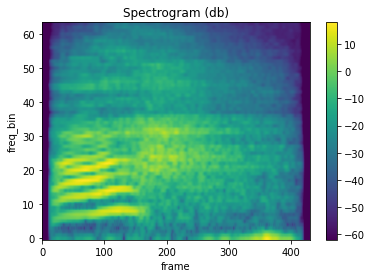

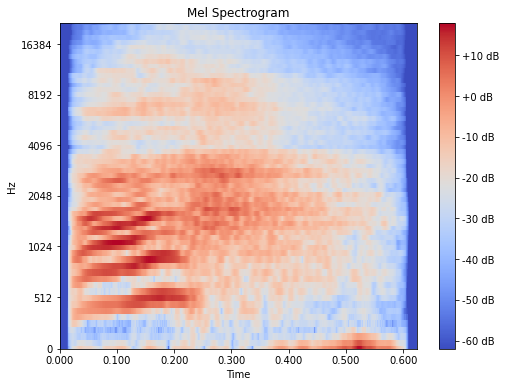

In [ ]:
n_fft = 1024
n_mels = 64
top_db = 80
hop_length = 64

melspec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, pad=1000)(audio)

print(melspec.size())


plot_spectrogram(melspec[0])

melspec = transforms.AmplitudeToDB(top_db = 80, stype = "power")(melspec)
# melspec = librosa.power_to_db(melspec[0].numpy(), ref=80)

plt.figure(figsize=(8,6))
librosa.display.specshow(melspec[0].numpy(), sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.title('Mel Spectrogram', fontsize=12);

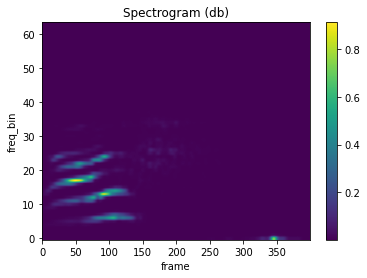

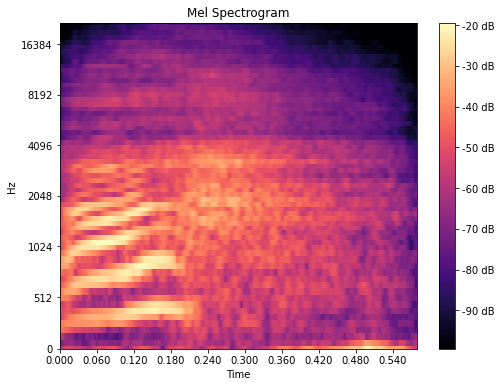

In [ ]:
melspec_librosa = librosa.feature.melspectrogram(
    audio.numpy()[0],
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    center=True,
    power=2.0,
    n_mels=n_mels,
)

plot_spectrogram(melspec_librosa)

melspec_librosa = librosa.power_to_db(melspec_librosa, ref=80)

plt.figure(figsize=(8,6))
librosa.display.specshow(melspec_librosa, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.title('Mel Spectrogram', fontsize=12);

# plot_spectrogram(
#     melspec_librosa, title="MelSpectrogram - librosa", ylabel='mel freq')

In [ ]:
mse = torch.square(melspec - melspec_librosa).mean().item()
print('Mean Square Difference: ', mse)

Mean Square Difference:  17.840179443359375


# Creating Dataset

In [82]:
audio_lengths = []
for count, i in enumerate(audio_paths):
    if count % 200 == 0:
        print(count)
    aud, sr = torchaudio.load(i)
    audio_lengths.append(aud.size()[1])

0
200
400
600
800
1000


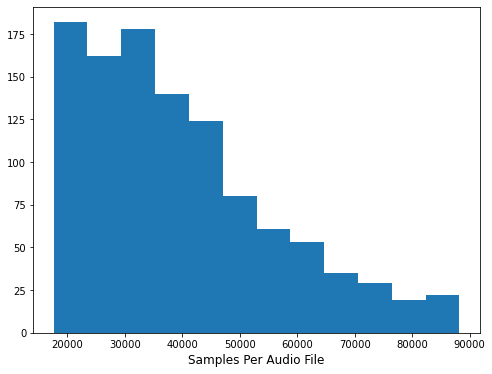

In [92]:
num_bins = 12
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(audio_lengths, num_bins)
plt.xlabel("Samples Per Audio File", fontsize = 12)
plt.show()

In [94]:
print(np.mean(audio_lengths))
print(np.min(audio_lengths))
print(np.max(audio_lengths))
print(np.median(audio_lengths))

39819.2064516129
17619
88200
35732.0


In [16]:
# Longest Audio Clip is 88200 samples
# max_length = 0

# for count, i in enumerate(audio_paths):
#   if count % 100 == 0:
#     print(count)

#   aud, sr = torchaudio.load(i)
#   if aud.size()[1] > max_length:
#     max_length = aud.size()[1]
#     j = i
# print(max_length)
# print(j)

# aud, _ = torchaudio.load("/content/drive/My Drive/VIVAE/full_set/S03_anger_moderate_01.wav")
aud, _ = torchaudio.load("../VIVAE/full_set/S03_anger_moderate_01.wav")
print(aud.size())

0
100
200
300
400
500
600
700
800
900
1000
88200
../VIVAE/full_set/S03_anger_moderate_01.wav
torch.Size([1, 88200])


In [6]:
class AudioDatasetViT(Dataset):
  def __init__(self, audio_paths, label_type, label_mapping, padding):
    super(AudioDatasetViT, self).__init__()
    self.audio_paths = audio_paths
    self.label_type = label_type 
    self.label_mapping = label_mapping
    self.padding = padding

  def __len__(self):
    return len(self.audio_paths)

  def __getitem__(self, idx):
      audio = Audio(self.audio_paths[idx], self.label_type, self.label_mapping)
      audio_padded = audio.pad_time_series(audio.get_audio(), self.padding)
      return audio.get_mel_spectrogram_and_label(audio_padded, n_mels=64)

class AudioDatasetMLP(Dataset):
  def __init__(self, audio_paths, label_type, label_mapping, padding):
    super(AudioDatasetMLP, self).__init__()
    self.audio_paths = audio_paths
    self.label_type = label_type 
    self.label_mapping = label_mapping
    self.padding = padding

  def __len__(self):
    return len(self.audio_paths)

  def __getitem__(self, idx):
      audio = Audio(self.audio_paths[idx], self.label_type, self.label_mapping)
      audio_padded = audio.pad_time_series(audio.get_audio(), self.padding)
      return audio.get_time_series_and_label(audio_padded)

In [21]:
# dataset = AudioDataset(audio_paths, LABEL_TYPE, LABEL_ENCODING)
# loader = DataLoader(dataset, shuffle=1, batch_size=10)

# dataset[1084][0].shape

torch.Size([1, 64, 690])

In [64]:
audio_arrays = np.load(os.path.join("./saved_arrays/", 'audio_arrays.npy'))
labels_arrays = np.load(os.path.join("./saved_arrays/", 'labels_arrays.npy'))
X_train, X_test, y_train, y_test = train_test_split(audio_arrays, labels_arrays, test_size=0.2, random_state=42)

In [78]:
a = Audio(audio_paths[0], LABEL_TYPE, LABEL_ENCODING)

In [80]:
a.get_audio().shape

torch.Size([1, 21125])

# Logistic Regression

In [73]:
# audio_classes = []

# for count, i in enumerate(audio_paths):
#   if count % 100 == 0:
#     print(count)
#   audio_classes.append(Audio(i, LABEL_TYPE, LABEL_ENCODING))

0
100
200
300
400
500
600
700
800
900
1000


In [74]:
# audio_arrays = []
# labels_arrays = []
# for i in audio_classes:
#   audio_padded = i.pad_time_series(i.get_audio(), 44100)
#   a,b = i.get_time_series_and_label(audio_padded)
#   audio_arrays.append(a.numpy())
#   labels_arrays.append(b)

# np.save(os.path.join("./saved_arrays/", 'audio_arrays.npy'), audio_arrays)
# np.save(os.path.join("./saved_arrays/", 'labels_arrays.npy'), labels_arrays)

In [75]:
audio_arrays = np.load(os.path.join("./saved_arrays/", 'audio_arrays.npy'))
labels_arrays = np.load(os.path.join("./saved_arrays/", 'labels_arrays.npy'))
X_train, X_test, y_train, y_test = train_test_split(audio_arrays, labels_arrays, test_size=0.2, random_state=42)

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg_model = LogisticRegression(penalty = "l2", 
                           max_iter = 1000) # call model from API

logreg_model.fit(X_train,y_train) # fit data using training
y_predict = logreg_model.predict(X_test) # predict model performance using test set
accuracy = logreg_model.score(X_test,y_test) # compute accuracy
print(accuracy) # 1-sum(abs(y_test.to_numpy().flatten() - y_predict))/len(y_predict)

0.2073732718894009


In [77]:
logreg_model.score(X_train, y_train)

0.9550691244239631

# MLP

In [218]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 200)
        self.fc3 = nn.Linear(200, 60)
        self.fc4 = nn.Linear(60, output_dim)
        self.dropout = nn.Dropout(0.25)
        # self.bn = nn.BatchNorm1d(44100)
    def forward(self, x):
        # x = self.bn(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [213]:
padding = 44100

dataset = AudioDatasetMLP(audio_paths, LABEL_TYPE, LABEL_ENCODING, padding)
dataset_size = len(dataset)

split = 0.2 # Train-Test split is 80% 20%
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

batch_size = 30
train_loader = DataLoader(train_set, 
                          shuffle = True, 
                          batch_size = batch_size)
test_loader = DataLoader(test_set, 
                        shuffle = True, 
                        batch_size = batch_size)

In [214]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(padding, 6).to(device)

learning_rate = 0.00002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-6) # 1e-6
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=10,  
                                            gamma=1)

In [222]:
%%time
output_dir = f"./MLP/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

EPOCHS = 100

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print("MLP")
start = time.time()
for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader):
        features, labels = data
        features = features.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        predictions = model(features)

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
        test_loss = 0.0 
        test_acc = 0.0
        for i, data in enumerate(test_loader):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set)
    test_acc = 100*test_acc.item()/len(test_set)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 25 == 0: # takes 100 seconds to run 100 epochs
        save_model(model, output_dir, epoch, test_loss, test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

df_MLP = save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir)

MLP
Epoch: 1 Train Loss: 45.4679 Test Loss: 14.2722 Train Acc: 60.2535% Test Acc: 17.0507%
Epoch: 2 Train Loss: 44.9788 Test Loss: 14.287 Train Acc: 62.0968% Test Acc: 17.0507%
Epoch: 3 Train Loss: 44.4328 Test Loss: 14.2858 Train Acc: 64.0553% Test Acc: 18.4332%
Epoch: 4 Train Loss: 43.8219 Test Loss: 14.3079 Train Acc: 66.4747% Test Acc: 18.4332%
Epoch: 5 Train Loss: 43.1863 Test Loss: 14.3106 Train Acc: 67.6267% Test Acc: 17.9724%
Epoch: 6 Train Loss: 42.5739 Test Loss: 14.2705 Train Acc: 69.7005% Test Acc: 17.0507%
Epoch: 7 Train Loss: 41.938 Test Loss: 14.3011 Train Acc: 70.6221% Test Acc: 17.0507%
Epoch: 8 Train Loss: 41.1831 Test Loss: 14.2556 Train Acc: 72.6959% Test Acc: 17.5115%
Epoch: 9 Train Loss: 40.7974 Test Loss: 14.2453 Train Acc: 73.9631% Test Acc: 17.9724%
Epoch: 10 Train Loss: 39.9906 Test Loss: 14.2776 Train Acc: 75.2304% Test Acc: 17.9724%
Epoch: 11 Train Loss: 39.2943 Test Loss: 14.2324 Train Acc: 76.2673% Test Acc: 18.4332%
Epoch: 12 Train Loss: 38.6903 Test Loss

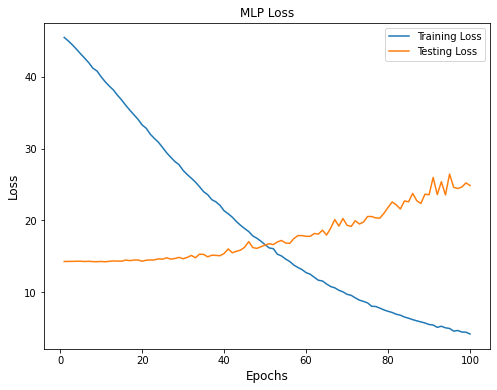

In [223]:
plot_loss(df_MLP, title="MLP Loss")

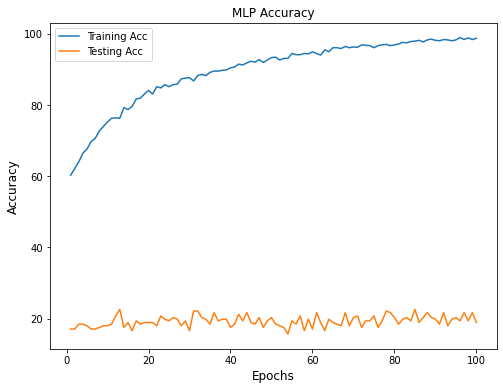

In [224]:
plot_accuracy(df_MLP, title="MLP Accuracy")

# ViT (32, 30)


In [9]:
padding = 44100

dataset = AudioDatasetViT(audio_paths, LABEL_TYPE, LABEL_ENCODING, padding)
dataset_size = len(dataset)

split = 0.2 # Train-Test split is 80% 20%
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

batch_size = 30
# Shape should be BATCH, 1 (Mono Channel), N_MELS, TIME_BINS -> torch.Size([8, 1, 64, 1379])
train_loader = DataLoader(train_set, 
                          shuffle = True, 
                          batch_size = batch_size)
test_loader = DataLoader(test_set, 
                        shuffle = True, 
                        batch_size = batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
#44100
patch_size = (32, 30)
model = ViT(
    image_size = (64, 690),
    patch_size = patch_size,
    num_classes = 6,
    dim = 200,
    depth = 5,
    heads = 16,
    mlp_dim = 300,
    dropout = 0.05,
    emb_dropout = 0.05,
    channels = 1
).to(device)

learning_rate = 0.000005 # 0.00002
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay = 1e-6)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=50,  
                                            gamma=0.98)

In [11]:
%%time
output_dir = f"./ViT_models_{patch_size[0]}_{patch_size[1]}/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

EPOCHS = 400

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print("ViT")
start = time.time()

for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
        test_loss = 0.0 
        test_acc = 0.0
        for i, data in enumerate(test_loader):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set)
    test_acc = 100*test_acc.item()/len(test_set)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 5 == 0:
        save_model(model, output_dir, epoch, test_loss, test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

df_ViT1 = save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir)

ViT
Epoch: 1 Train Loss: 53.8201 Test Loss: 14.2807 Train Acc: 18.0876% Test Acc: 21.1982%
Epoch: 2 Train Loss: 51.7992 Test Loss: 14.0325 Train Acc: 18.5484% Test Acc: 25.8065%
Epoch: 3 Train Loss: 51.3827 Test Loss: 14.1401 Train Acc: 23.2719% Test Acc: 25.3456%
Epoch: 4 Train Loss: 51.0606 Test Loss: 13.9932 Train Acc: 24.3088% Test Acc: 21.659%
Epoch: 5 Train Loss: 50.828 Test Loss: 13.7486 Train Acc: 25.1152% Test Acc: 28.5714%
Epoch: 6 Train Loss: 50.3734 Test Loss: 13.7718 Train Acc: 25.9217% Test Acc: 34.5622%
Epoch: 7 Train Loss: 49.9409 Test Loss: 13.8664 Train Acc: 29.3779% Test Acc: 31.7972%
Epoch: 8 Train Loss: 49.9577 Test Loss: 13.7446 Train Acc: 28.1106% Test Acc: 30.8756%
Epoch: 9 Train Loss: 49.546 Test Loss: 13.5273 Train Acc: 30.1843% Test Acc: 31.3364%
Epoch: 10 Train Loss: 49.2659 Test Loss: 13.452 Train Acc: 30.9908% Test Acc: 33.1797%
Epoch: 11 Train Loss: 49.3388 Test Loss: 13.5587 Train Acc: 28.9171% Test Acc: 35.4839%
Epoch: 12 Train Loss: 49.0103 Test Loss: 

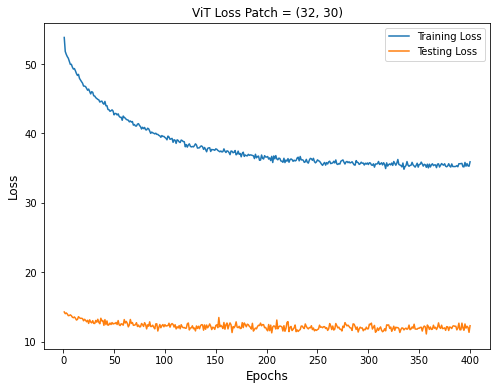

In [12]:
plot_loss(df_ViT1, title=f"ViT Loss Patch = {patch_size}")

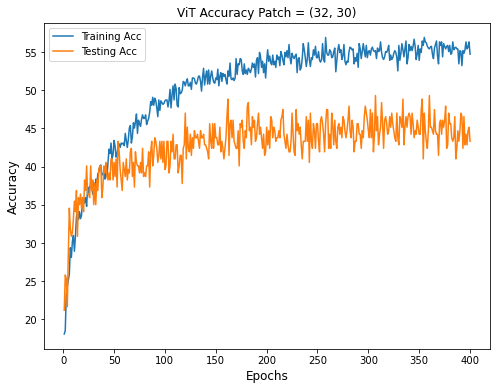

In [13]:
plot_accuracy(df_ViT1, title=f"ViT Accuracy Patch = {patch_size}")

In [34]:
# x, y = next(iter(train_loader))
# x = x.to(device)
# y = y.to(device)

# model.eval()
# (torch.argmax(model(x), dim=1) == y).float().mean()

# ViT (16, 69)

In [16]:
padding = 44100

dataset = AudioDatasetViT(audio_paths, LABEL_TYPE, LABEL_ENCODING, padding)
dataset_size = len(dataset)

split = 0.2 # Train-Test split is 80% 20%
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

batch_size = 30
# Shape should be BATCH, 1 (Mono Channel), N_MELS, TIME_BINS -> torch.Size([8, 1, 64, 1379])
train_loader = DataLoader(train_set, 
                          shuffle = True, 
                          batch_size = batch_size)
test_loader = DataLoader(test_set, 
                        shuffle = True, 
                        batch_size = batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# 88200
# model = ViT(
#     image_size = (64, 1379),
#     patch_size = (32, 197),
#     num_classes = 6,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1,
#     channels = 1
# ).to(device)

#44100
patch_size = (16, 69)
model = ViT(
    image_size = (64, 690),
    patch_size = patch_size,
    num_classes = 6,
    dim = 200,
    depth = 5,
    heads = 16,
    mlp_dim = 300,
    dropout = 0.05,
    emb_dropout = 0.05,
    channels = 1
).to(device)

learning_rate = 0.000005 # 0.00002
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay = 1e-6)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=50,  
                                            gamma=0.98)

In [18]:
%%time
output_dir = f"./ViT_models_{patch_size[0]}_{patch_size[1]}/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

EPOCHS = 400

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print("ViT")
start = time.time()

for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
        test_loss = 0.0 
        test_acc = 0.0
        for i, data in enumerate(test_loader):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set)
    test_acc = 100*test_acc.item()/len(test_set)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 5 == 0:
        save_model(model, output_dir, epoch, test_loss, test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

df_ViT2 = save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir)

ViT
Epoch: 1 Train Loss: 52.5392 Test Loss: 14.5265 Train Acc: 17.5115% Test Acc: 13.8249%
Epoch: 2 Train Loss: 52.2113 Test Loss: 14.4014 Train Acc: 17.5115% Test Acc: 17.9724%
Epoch: 3 Train Loss: 51.7905 Test Loss: 14.3775 Train Acc: 19.1244% Test Acc: 17.9724%
Epoch: 4 Train Loss: 52.2518 Test Loss: 14.1765 Train Acc: 18.0876% Test Acc: 24.8848%
Epoch: 5 Train Loss: 51.4961 Test Loss: 14.3016 Train Acc: 24.8848% Test Acc: 22.5806%
Epoch: 6 Train Loss: 51.3271 Test Loss: 14.1453 Train Acc: 25.1152% Test Acc: 23.0415%
Epoch: 7 Train Loss: 51.1807 Test Loss: 14.1395 Train Acc: 24.1935% Test Acc: 23.9631%
Epoch: 8 Train Loss: 51.0414 Test Loss: 14.1714 Train Acc: 25.6912% Test Acc: 24.424%
Epoch: 9 Train Loss: 50.7798 Test Loss: 14.0838 Train Acc: 25.9217% Test Acc: 22.1198%
Epoch: 10 Train Loss: 50.6316 Test Loss: 14.062 Train Acc: 28.6866% Test Acc: 24.424%
Epoch: 11 Train Loss: 50.3742 Test Loss: 13.9662 Train Acc: 27.765% Test Acc: 28.1106%
Epoch: 12 Train Loss: 50.1663 Test Loss: 

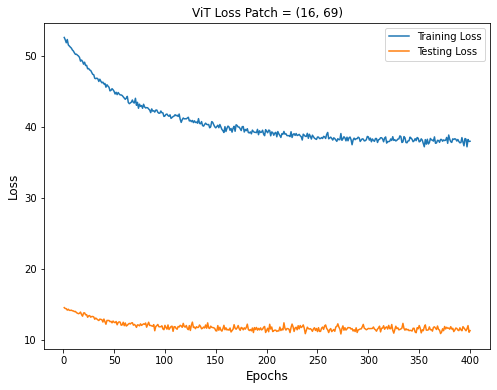

In [19]:
plot_loss(df_ViT2, title=f"ViT Loss Patch = {patch_size}")

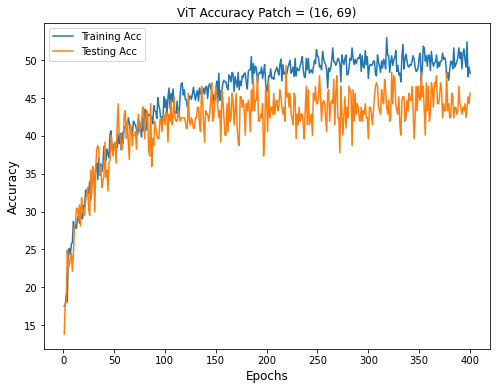

In [20]:
plot_accuracy(df_ViT2, title=f"ViT Accuracy Patch = {patch_size}")

In [34]:
# x, y = next(iter(train_loader))
# x = x.to(device)
# y = y.to(device)

# model.eval()
# (torch.argmax(model(x), dim=1) == y).float().mean()

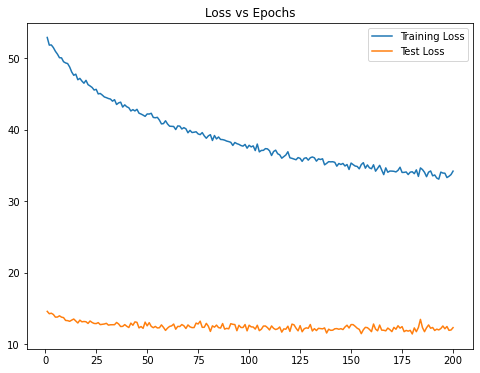

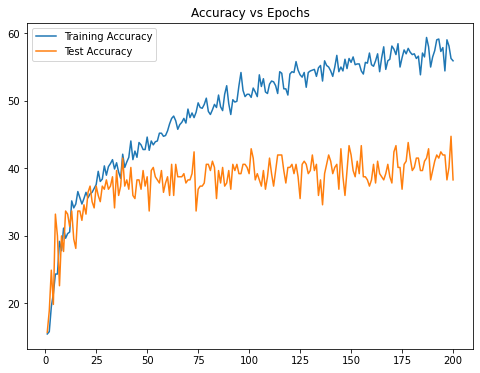

In [24]:
_epochs = [i for i in range(1, EPOCHS+1)]

up_to = min(len(train_losses), len(test_losses))

plt.figure(figsize = (8,6))
plt.plot(_epochs[:up_to], train_losses[:up_to], label = "Training Loss")
plt.plot(_epochs[:up_to], test_losses[:up_to], label = "Test Loss")
plt.title("Loss vs Epochs", fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(_epochs[:up_to], train_accs[:up_to], label = "Training Accuracy")
plt.plot(_epochs[:up_to], test_accs[:up_to], label = "Test Accuracy")
plt.title("Accuracy vs Epochs", fontsize=12)
plt.legend()
plt.show()

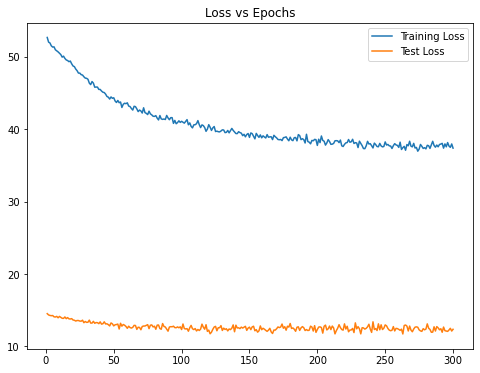

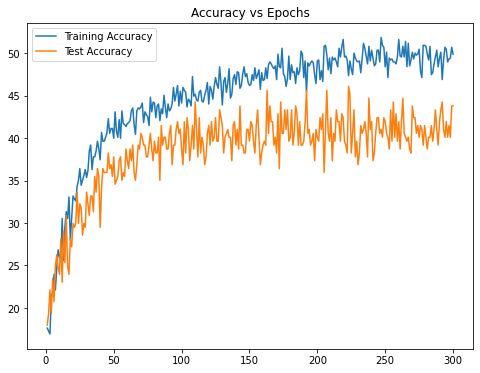

In [31]:
_epochs = [i for i in range(1, EPOCHS+1)]

up_to = min(len(train_losses), len(test_losses))

plt.figure(figsize = (8,6))
plt.plot(_epochs[:up_to], train_losses[:up_to], label = "Training Loss")
plt.plot(_epochs[:up_to], test_losses[:up_to], label = "Test Loss")
plt.title("Loss vs Epochs", fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(_epochs[:up_to], train_accs[:up_to], label = "Training Accuracy")
plt.plot(_epochs[:up_to], test_accs[:up_to], label = "Test Accuracy")
plt.title("Accuracy vs Epochs", fontsize=12)
plt.legend()
plt.show()

# Patch

In [24]:
padding = 44100

dataset = AudioDatasetViT(audio_paths, LABEL_TYPE, LABEL_ENCODING, padding)
dataset_size = len(dataset)

split = 0.2 # Train-Test split is 80% 20%
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

batch_size = 30
# Shape should be BATCH, 1 (Mono Channel), N_MELS, TIME_BINS -> torch.Size([8, 1, 64, 1379])
train_loader = DataLoader(train_set, 
                          shuffle = True, 
                          batch_size = batch_size)
test_loader = DataLoader(test_set, 
                        shuffle = True, 
                        batch_size = batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# 88200
# model = ViT(
#     image_size = (64, 1379),
#     patch_size = (32, 197),
#     num_classes = 6,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1,
#     channels = 1
# ).to(device)

#44100
patch_size = (8, 23)
model = ViT(
    image_size = (64, 690),
    patch_size = patch_size,
    num_classes = 6,
    dim = 200,
    depth = 5,
    heads = 16,
    mlp_dim = 300,
    dropout = 0.05,
    emb_dropout = 0.05,
    channels = 1
).to(device)

learning_rate = 0.000005 # 0.00002
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay = 1e-6)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=50,  
                                            gamma=0.98)

In [26]:
%%time
output_dir = f"./ViT_models_{patch_size[0]}_{patch_size[1]}/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

EPOCHS = 400

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print(f"ViT {patch_size}")
start = time.time()

for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
        test_loss = 0.0 
        test_acc = 0.0
        for i, data in enumerate(test_loader):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set)
    test_acc = 100*test_acc.item()/len(test_set)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 5 == 0:
        save_model(model, output_dir, epoch, test_loss, test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

df_ViT3 = save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir)

ViT (8, 23)
Epoch: 1 Train Loss: 54.0973 Test Loss: 14.6526 Train Acc: 15.553% Test Acc: 15.2074%
Epoch: 2 Train Loss: 52.5591 Test Loss: 14.4526 Train Acc: 13.7097% Test Acc: 17.0507%
Epoch: 3 Train Loss: 52.5348 Test Loss: 14.461 Train Acc: 14.1705% Test Acc: 15.2074%
Epoch: 4 Train Loss: 52.3532 Test Loss: 14.4687 Train Acc: 16.5899% Test Acc: 17.5115%
Epoch: 5 Train Loss: 52.4208 Test Loss: 14.5407 Train Acc: 17.0507% Test Acc: 14.2857%
Epoch: 6 Train Loss: 52.0686 Test Loss: 14.3353 Train Acc: 18.5484% Test Acc: 23.0415%
Epoch: 7 Train Loss: 51.8769 Test Loss: 14.2256 Train Acc: 19.5853% Test Acc: 22.5806%
Epoch: 8 Train Loss: 51.7559 Test Loss: 14.3164 Train Acc: 20.2765% Test Acc: 22.5806%
Epoch: 9 Train Loss: 51.7676 Test Loss: 14.2367 Train Acc: 20.0461% Test Acc: 21.659%
Epoch: 10 Train Loss: 51.7741 Test Loss: 14.3181 Train Acc: 21.5438% Test Acc: 20.7373%
Epoch: 11 Train Loss: 51.7162 Test Loss: 14.405 Train Acc: 20.2765% Test Acc: 22.5806%
Epoch: 12 Train Loss: 51.5135 Tes

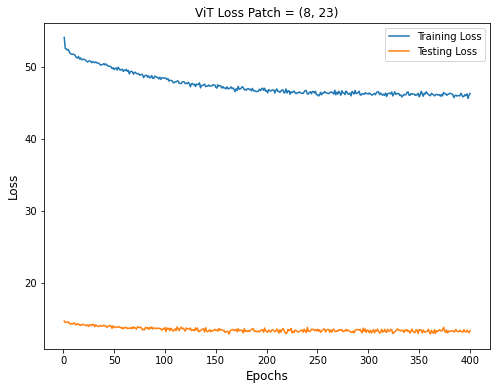

In [27]:
plot_loss(df_ViT3, title=f"ViT Loss Patch = {patch_size}")

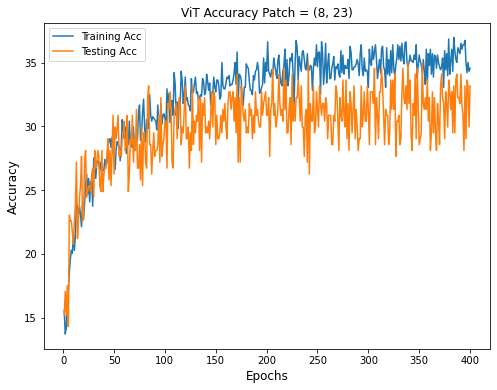

In [28]:
plot_accuracy(df_ViT3, title=f"ViT Accuracy Patch = {patch_size}")

# Using wav2vec2

In [32]:
dir(torchaudio.models.wav2vec2)

['HuBERTPretrainModel',
 'Wav2Vec2Model',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'components',
 'hubert_base',
 'hubert_large',
 'hubert_pretrain_base',
 'hubert_pretrain_large',
 'hubert_pretrain_model',
 'hubert_pretrain_xlarge',
 'hubert_xlarge',
 'model',
 'utils',
 'wav2vec2_base',
 'wav2vec2_large',
 'wav2vec2_large_lv60k',
 'wav2vec2_model']

In [33]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE  
print("Sample Rate:", bundle.sample_rate)

# print("Labels:", bundle.get_labels())

# print("Labels Count:", len(bundle.get_labels()))

model = bundle.get_model()

Sample Rate: 16000


In [69]:
# torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.aux = nn.Linear(768, 6)
model = model.to(device)

assert next(model.parameters()).is_cuda, "Model is not on GPU"

In [34]:
from torchaudio.models.wav2vec2.utils import import_fairseq_model
import fairseq

model_file = './fairseq_models/wav2vec_small.pt'
# model_file = './fairseq_models/wav2vec_small.pt'

model, _, _ = fairseq.checkpoint_utils.load_model_ensemble_and_task([model_file])
original = model[0]
imported = import_fairseq_model(original)

In [58]:
from torchaudio.models import wav2vec2_large
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = wav2vec2_large(aux_num_out = 6)
model = model.to(device)

In [59]:
padding = 44100

dataset = AudioDatasetMLP(audio_paths, LABEL_TYPE, LABEL_ENCODING, padding)
dataset_size = len(dataset)

split = 0.2 # Train-Test split is 80% 20%
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

batch_size = 1
train_loader = DataLoader(train_set, 
                          shuffle = True, 
                          batch_size = batch_size)
test_loader = DataLoader(test_set, 
                        shuffle = True, 
                        batch_size = batch_size)

In [60]:
# Change from 29 to 6

learning_rate = 0.000005 # 0.00002
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay = 1e-6)
criterion = nn.CTCLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=50,  
                                            gamma=0.98)

In [61]:
%%time
EPOCHS = 100

train_losses = []
train_accs = []

test_losses = []
test_accs = []

model.train() 

print("Wav2Vec2")
start = time.time()
for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader):
        features, labels = data
        features = features.to(device)
        labels = labels.type(torch.LongTensor).to(device)

        # print(features.shape)
        predictions, _ = model(features)
        print(predictions.shape)
        print(labels.shape)
        # predictions = predictions[:,0,:]
        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
        test_loss = 0.0 
        test_acc = 0.0
        for i, data in enumerate(test_loader):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set)
    test_acc = 100*test_acc.item()/len(test_set)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

Wav2Vec2
torch.Size([1, 137, 6])
torch.Size([1])


TypeError: forward() missing 2 required positional arguments: 'input_lengths' and 'target_lengths'

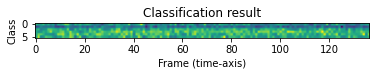

In [64]:
plt.imshow(predictions[0].detach().cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()


In [56]:
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size
S = 30      # Target sequence length of longest target in batch (padding length)
S_min = 10  # Minimum target length, for demonstration purposes

# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()

# Initialize random batch of targets (0 = blank, 1:C = classes)
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)

input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()

In [57]:
input.shape

torch.Size([50, 16, 20])

In [52]:
target.shape

torch.Size([16, 30])

In [53]:
input_lengths

tensor([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

In [54]:
target_lengths

tensor([15, 28, 15, 14, 23, 29, 24, 11, 18, 11, 24, 11, 12, 16, 23, 29])

In [15]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    4855 MB |    7166 MB |    1660 GB |    1656 GB |
|       from large pool |    4850 MB |    7121 MB |    1654 GB |    1650 GB |
|       from small pool |       5 MB |      45 MB |       6 GB |       6 GB |
|---------------------------------------------------------------------------|
| Active memory         |    4855 MB |    7166 MB |    1660 GB |    1656 GB |
|       from large pool |    4850 MB |    7121 MB |    1654 GB |

# Using HuggingFace

In [6]:
from datasets import Dataset as HFDataset, DatasetDict, load_metric, Audio as HFAudio, ClassLabel

dataset_dir = "/home/jupyter/VIVAE/full_set/"

abs_audio_paths = [os.path.join(dataset_dir, i) for i in os.listdir(dataset_dir)] # must be absolute path
abs_audio_paths_label = [LABEL_ENCODING[i.split("/")[-1].split("_")[1]] for i in abs_audio_paths] # gives number of class label

abs_audio_paths_dict = {"audio": abs_audio_paths, "label": abs_audio_paths_label}
dataset = HFDataset.from_dict(abs_audio_paths_dict)

# https://huggingface.co/docs/datasets/audio_process#resample
dataset = dataset.cast_column("audio", HFAudio(sampling_rate=44100, mono=True)) # turn audio path into actual audio with sampling rate
dataset = dataset.cast_column("label", ClassLabel(num_classes=6, names=list(LABEL_ENCODING.keys())))

dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed=SEED) # convert Dataset to DatasetDict with training and testing splits

dataset

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 868
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 217
    })
})

In [7]:
for i in range(len(dataset["train"])):
    if i < 3:
        print(f'sr: {dataset["train"][i]["audio"]["sampling_rate"]}')
        print(f'samples: {len(dataset["train"][i]["audio"]["array"])}')
    else: 
        break

sr: 44100
samples: 57160
sr: 44100
samples: 63439
sr: 44100
samples: 28444


In [8]:
assert dataset["train"].features == dataset["test"].features, "Should be same datatypes"
dataset["train"].features

{'audio': Audio(sampling_rate=44100, mono=True, decode=True, id=None),
 'label': ClassLabel(num_classes=6, names=['achievement', 'anger', 'fear', 'pain', 'pleasure', 'surprise'], id=None)}

In [9]:
from transformers import AutoFeatureExtractor

model_checkpoint = "facebook/wav2vec2-base-960h"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [10]:
max_duration = 1 # second
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(audio_arrays, 
                               sampling_rate=feature_extractor.sampling_rate, 
                               max_length=int(feature_extractor.sampling_rate*max_duration), 
                               truncation=True,)
    return inputs

In [11]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio"], batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# encoded_dataset["train"][0:2]["input_values"]

In [11]:
preprocess_function(dataset["train"][:2])["input_values"]

[array([1.6856360e-03, 2.5933052e-03, 2.8958614e-03, ..., 1.8109726e+00,
        1.9374411e+00, 1.9259440e+00], dtype=float32),
 array([-0.11270893, -0.12212291, -0.07505299, ..., -0.28216064,
        -0.2633327 , -0.28216064], dtype=float32)]

In [ ]:
# for i in range(len(encoded_dataset["train"])):
#     if i < 10:
#         # print(dataset["train"][i]["audio"]["sampling_rate"])
#         print(len(encoded_dataset["train"][i]["input_values"]))
#     else: 
#         break

In [12]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

label2id = LABEL_ENCODING
id2label = dict((v,k) for k,v in label2id.items())
num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label
)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['projector.weight', 'classifier.weight', 'classifier.bias', 'projector.bias', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be 

In [13]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    metric1 = load_metric("accuracy")
    predictions = np.argmax(eval_pred.predictions, axis=1)
    
    accuracy = metric1.compute(predictions=predictions, references=eval_pred.label_ids)
    # return {"accuracy": accuracy}
    return accuracy

def save_hf_logs(logs, save=True):
    logs = logs[:-1]
    del logs[1::3]
    logs_list = []
    for i in range(0,len(logs),2):
        temp_dict = dict()
        temp_dict["epoch"] = int(logs[i]["epoch"] + 1)
        temp_dict["train_loss"] = logs[i]["train_loss"]
        temp_dict["train_accuracy"] = logs[i]["train_accuracy"]
        temp_dict["eval_loss"] = logs[i+1]["eval_loss"]
        temp_dict["eval_accuracy"] = logs[i+1]["eval_accuracy"]
        temp_dict["step"] = logs[i]["step"]
        logs_list.append(temp_dict)
    df = pd.DataFrame(logs_list)
    if save:
        df.to_pickle(os.path.join(output_dir, "logs.pkl"))
    return df

In [14]:
from transformers import TrainerCallback
from copy import deepcopy
# https://stackoverflow.com/a/70564009
class CustomCallback(TrainerCallback):
    
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

In [16]:
batch_size = 40
EPOCHS = 200
output_dir = "./hf_models/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    logging_strategy="epoch", # log training data stats
    learning_rate=15e-6, #originally 2e-5
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    logging_steps=10,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    save_total_limit = 2,
    save_strategy = "no",
    load_best_model_at_end=False,
)

trainer = Trainer(
    model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)
trainer.add_callback(CustomCallback(trainer))

In [17]:
%%time
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 868
  Num Epochs = 200
  Instantaneous batch size per device = 40
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 4
  Total optimization steps = 1000


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,1.790314,0.207373
0,1.970300,1.789909,0.216590
1,1.970300,1.788770,0.207373
1,1.969800,1.789993,0.179724
2,1.969800,1.787048,0.210829
2,1.968200,1.788052,0.188940
3,1.968200,1.784447,0.224654
3,1.966500,1.785588,0.230415
4,1.966500,1.780572,0.246544
4,1.963900,1.784325,0.239631


***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evalua

CPU times: user 3h 8min 32s, sys: 41min 47s, total: 3h 50min 20s
Wall time: 3h 16min 47s


TrainOutput(global_step=1000, training_loss=1.253267383337021, metrics={'train_runtime': 11807.8724, 'train_samples_per_second': 14.702, 'train_steps_per_second': 0.085, 'total_flos': 1.575450404810496e+18, 'train_loss': 1.253267383337021, 'epoch': 199.91})

In [18]:
df = save_hf_logs(trainer.state.log_history)
df.head()

,epoch,train_loss,train_accuracy,eval_loss,eval_accuracy,step
0,1,1.790314,0.207373,1.789909,0.216590,5
1,2,1.788770,0.207373,1.789993,0.179724,10
2,3,1.787048,0.210829,1.788052,0.188940,15
3,4,1.784447,0.224654,1.785588,0.230415,20
4,5,1.780572,0.246544,1.784325,0.239631,25


In [19]:
trainer.save_model()

Saving model checkpoint to ./hf_models/2022-05-03_15-43-45
Configuration saved in ./hf_models/2022-05-03_15-43-45/config.json
Model weights saved in ./hf_models/2022-05-03_15-43-45/pytorch_model.bin
Feature extractor saved in ./hf_models/2022-05-03_15-43-45/preprocessor_config.json


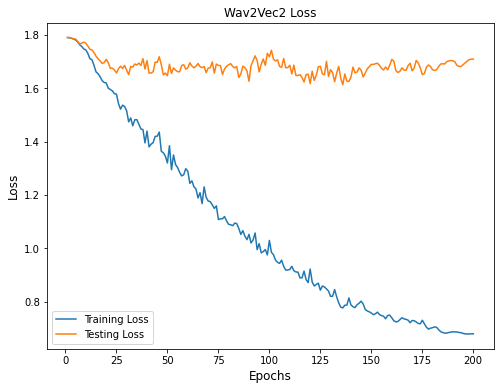

In [20]:
plot_loss(df, title="Wav2Vec2 Loss")

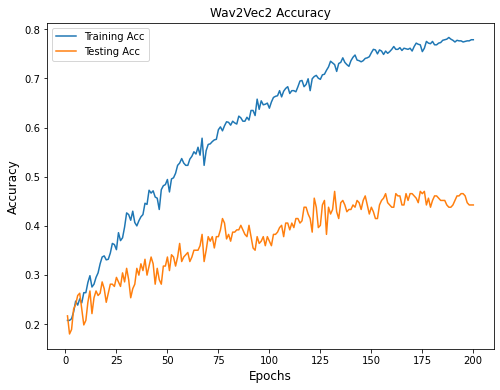

In [21]:
plot_accuracy(df, title="Wav2Vec2 Accuracy")

In [57]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 868
  Batch size = 40


{'eval_loss': 1.7142257690429688,
 'eval_accuracy': {'accuracy': 0.2799539170506912},
 'eval_runtime': 14.2766,
 'eval_samples_per_second': 60.799,
 'eval_steps_per_second': 1.541,
 'epoch': 1.91}